In [1]:
import os
import scvi
import scgen
import rpy2
import scib
import json
import torch
import anndata
import logging
import warnings
import scanorama
import anndata2ri
import matplotlib
import liana as li
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sb
import cell2cell as c2c
import plotnine as p9
import scrublet as scr
import doubletdetection
import decoupler as dc
from rpy2.robjects import r
from anndata import AnnData
from tabnanny import verbose
import matplotlib.pyplot as plt
from os import PathLike, fspath
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams
from liana.method import cellphonedb
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from rpy2.robjects.conversion import localconverter

Global seed set to 0
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be r

In [2]:
def get_sys_dpi(width, height, diag):
    '''
    obtain dpi of system
    
    w: width in pixels (if unsure, go vist `whatismyscreenresolution.net`)
    h: height in pixels
    d: diagonal in inches
    '''
    w_inches = (diag**2/ (1 + height**2/width**2))**0.5
    return round(width/w_inches)

In [3]:
%%R
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(purrr)
    library(tibble)
})


UsageError: Cell magic `%%R` not found.


In [4]:
# # Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# # Automatically convert rpy2 outputs to pandas dataframes
# pandas2ri.activate()
# anndata2ri.activate()
# %load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()



/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:351: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.


-----
anndata     0.8.0
scanpy      1.9.1
-----
OpenSSL                                     22.0.0
PIL                                         9.2.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
adjustText                                  NA
anndata2ri                                  1.1
annoy                                       NA
appnope                                     0.1.2
asttokens                                   NA
astunparse                                  1.6.3
attr                                        21.4.0
backcall                                    0.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
boto3                                       1.26.32
botocore                                    1.29.32
bottleneck                                  1.3.5
brotli                                      NA
cell2cell                                   0.6.6
certifi               

## Table of contents:

  * <a href=#Reading>1. Reading in the data</a>
  * <a href=#Preprocessing>2. Cell-Cell Communication</a>

# 1. Reading in the data

### [Mathys et. al. 2019](https://doi.org/10.1038/s41586-019-1195-2) (Prefrontal Cortex)

Now, we load the preprocessed and annotated data for downstream analysis.

In [5]:
adata_annot = sc.read_h5ad('../data/processed/adata_annotated.h5ad')
adata_annot = adata_annot[~adata_annot.obs.cell_type.isin(['Endothelial'])]

In [6]:
#adata_annot = adata_annot[:, adata_annot.var.highly_variable=="True"]
adata_annot

View of AnnData object with n_obs × n_vars = 65297 × 16590
    obs: 'projid', 'fastq', 'Subject', 'sample', 'libraryid', 'study', 'age_death', 'educ', 'msex_x', 'gpath_x', 'amyloid_x', 'plaq_n_x', 'cogdx_x', 'pathologic diagnosis of AD', 'amyloid_y', 'plaq_n_y', 'nft', 'tangles', 'cogn_global_lv', 'gpath_y', 'gpath_3neocort', 'amyloid.group', 'caa_4gp', 'ceradsc', 'braaksc', 'niareagansc', 'cogdx_y', 'msex_y', 'pathology.group', 'sampleid', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'louvain_0.5', 'louvain_1.0', 'cell_type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Subject_colors', 'amyloid.group_colors', 'braaksc_colors', 'dendrogram_louvain_0.5', 'hvg', 'log1p', 'louvain', 'louvain_0.5_colors', 'louvain_1.0_colors', 'msex_x_colors'

# 2 **Cell-Cell Communication**

## `Predicting inter-cellular crosstalk between pair of clusters, one cluster being the source and the other the target of a CCC event.`


**Summary**:

- In general, single cells are clustered by their gene expression profile and cell type identities are assigned to the clusters based on known gene markers. Then, CCC tools can predict intercellular crosstalk between any pair of clusters, one cluster being the source and the other the target of a CCC event. 

- CCC events are thus typically represented as a oneto-one interaction between a transmitter and receiver protein, accordingly expressed by the source and target cell clusters. 

- The information about which transmitter binds to which receiver is extracted from diverse sources of prior knowledge. Roughly, CCC tools then estimate the likelihood of crosstalk based on the expression level of the transmitter and the receiver in the source and target clusters, respectively. 

- Every tool has two major components: a resource of prior knowledge on CCC (interactions), and a method to estimate CCC from the known interactions and the dataset at hand. Most tools have been published as the combination of one resource and one method, but in principle any resource could be combined with any method.

## 2.1 **Generating a Ligand-Receptor consensus with `LIANA`**

As a way to further increase the confidence in a potential interaction of interest, one could check if this interaction is predicted as relevant by more than a single method. This is important given the reported limited agreement between the interactions inferred by different ligand-receptor methods.

In the same manner, we use multiple methods and focus on their consensus, or in other words focus on interactions consistently predicted as relevant. To this end, we will run the `rank_aggregate` method of `liana` [**Dimitrov et al., 2022**](https://www.nature.com/articles/s41467-022-30755-0), which generates a probability distribution of highly ranked interactions across the methods.

Let’s first examine the ligand-receptor methods in LIANA:

In [7]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Let’s now run the Rank_Aggregate method, which will essentially run the other methods in the background and then generate a consensus.

In [8]:
adata_cond = {}
adata_cond['stim'] = adata_annot[adata_annot.obs["pathology.group"].isin(['early-pathology', 'late-pathology'])].copy()
adata_cond['ctrl'] = adata_annot[adata_annot.obs["pathology.group"].isin(['no-pathology'])].copy()

del adata_annot

In [9]:
for cond in adata_cond.keys():
    print(f'Estimating aggregate LR-scores for {cond}...')
    # select only fraction of data because of memory issues 
    
    # strata = adata_cond[cond].obs.cell_type
    # adata_train, adata_test = train_test_split(adata_cond[cond], test_size=0.5, train_size=None, random_state=None,
    #                                             shuffle=True, stratify=strata)
    # adata_cond[cond] = adata_test
    # del strata, adata_train, adata_test

    li.method.rank_aggregate(adata_cond[cond], groupby="cell_type", return_all_lrs=True, use_raw=False, verbose=True, n_perms=200)

Estimating aggregate LR-scores for stim...
Using `.X`!
Converting mat to CSR format
0.09 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 15611 samples and 16590 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [00:24<00:00,  8.27it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/sc/_singlecellsignalr.py:21: RuntimeWarning: invalid value encountered in sqrt


Running CellChat


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [02:19<00:00,  1.43it/s]


Estimating aggregate LR-scores for ctrl...
Using `.X`!
Converting mat to CSR format
0.09 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 17038 samples and 16590 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/sc/_singlecellsignalr.py:21: RuntimeWarning: invalid value encountered in sqrt


Running CellChat


/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/liana/method/_pipe_utils/_get_mean_perms.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


In [10]:
adata_cond['stim'].uns["liana_res"].drop_duplicates(["ligand_complex", "receptor_complex"]).head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
115641,OPC,OPC,PTN,PTPRZ1,2.290080,0.0,4.079124,2.232160,3.222166,0.677312,1.003694,0.088955,0.0,0.001043,0.002566,1.619187e-07
110629,Microglia,OPC,C3,GRM7,2.503080,0.0,4.896247,2.365868,5.590591,-14.487784,1.003370,0.053497,0.0,0.000147,0.000082,2.529911e-07
16581,OPC,Astrocyte,VCAN,EGFR,2.809309,0.0,5.558344,2.681943,4.819851,0.689598,1.003162,0.052222,0.0,0.000739,0.000493,2.878450e-07
109649,Microglia,OPC,C3,LRP1,2.439527,0.0,4.429366,2.290961,5.891696,0.727977,1.003544,0.045009,0.0,0.000074,0.000041,3.642972e-07
12510,Microglia,Astrocyte,ST6GAL1,EGFR,2.166598,0.0,3.910939,2.146804,4.539509,0.573143,1.003772,0.036794,0.0,0.001043,0.001027,1.982961e-06


Here, we can see the output of the scoring functions of all methods.

More importantly, we also get the `magnitude_rank` and `specificity_rank` for each interaction, `which represent the consensus interaction magnitude (strength of expression) and specificity (across all cell type pairs)`, respectively. For example, going back to CellPhoneDB, lr_mean and cellphone_pvals will be correspondingly aggregated into those.

Let’s generate the same plot, but now using the aggregate of the methods:


visualization LR dotplots in AD group


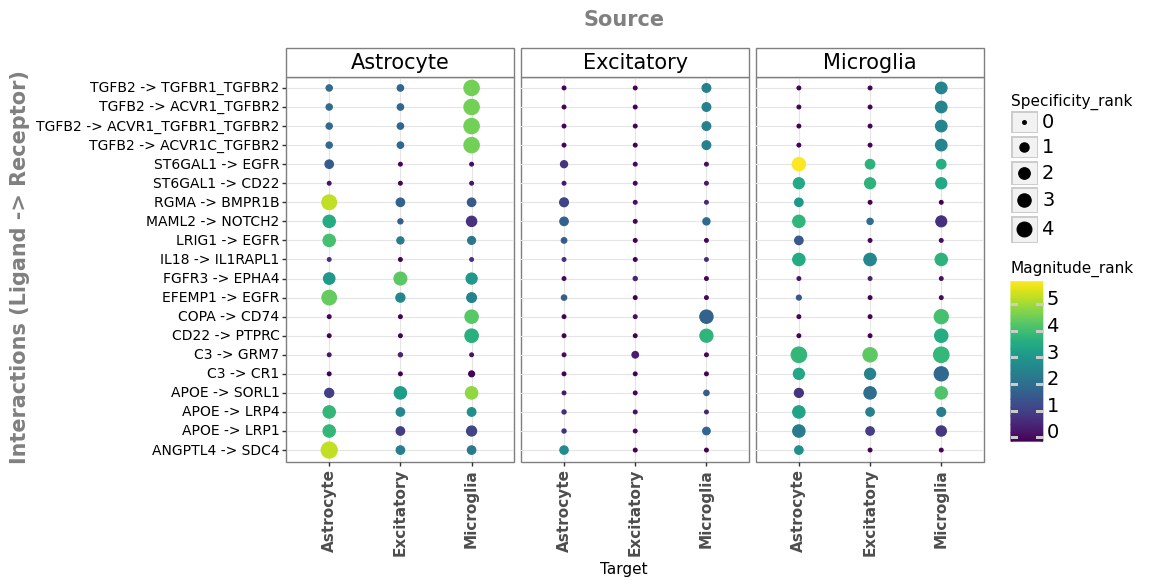

<ggplot: (713562764)>

In [11]:
print('=====================================')
print('visualization LR dotplots in AD group')
print('=====================================')
      
li.pl.dotplot(
    adata=adata_cond['stim'],
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["Excitatory", "Astrocyte", "Microglia"],
    target_labels=["Excitatory", "Astrocyte", "Microglia"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

visualization LR dotplots in WT group


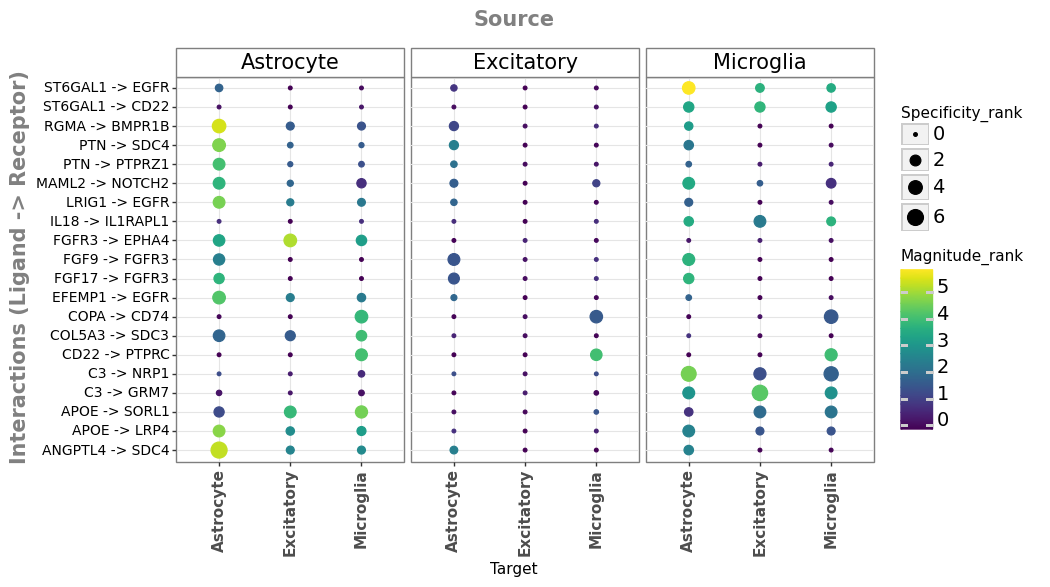

<ggplot: (1914735499)>

In [12]:
print('=====================================')
print('visualization LR dotplots in WT group')
print('=====================================')

li.pl.dotplot(
    adata=adata_cond['ctrl'],
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["Excitatory", "Astrocyte", "Microglia"],
    target_labels=["Excitatory", "Astrocyte", "Microglia"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

### **Biological Findings**

Now that we've obtained a consensus result, we can see at first glance, that the following top LR-pairs distinctly present in only one conditon.


|  LIGAND     | RECEPTOR     | CONDITION |
| ----------- | ----------- | ----------- |
| TGFB2 | ACVR1_TGFBR1_TGFBR2 | `AD` |
| COPA | CD74 | `AD` |
| C3 | CD46 | `AD` |
| APOE | LRP1 | `AD` |
| PTN | SDC4 | WT |
| PTN | PTPRZ1 | WT |
| FGF2/9/17 | FGFR3 | WT |
| FGF2 | SDC4 | WT |
| COL5A3| SDC3 | WT |




Herein, we provide a comprehensive analysis of the intricate network of ligand-receptor pairs (LR-pairs) expressed uniquely in normal and disease condition

- **`TGFB2 --> ACVR1_TGFBR1_TGFBR2 Signalling in AD`**
    - The TGF-β signaling axis plays a critical role in disease pathogenesis. Specifically, the signaling axis has diverse roles in both amyloid-beta (Aβ) deposition and clearance, as well as tau pathology and neurofibrillary tangle formation. The deficiency of TGF-β1 signaling has been demonstrated to exacerbate Aβ accumulation and Aβ-induced neurodegeneration in AD models. Conversely, TGF-β1 appears to exert a neuroprotective effect against Aβ toxicity, as evidenced by studies utilizing in vitro and in vivo AD models. 
    
    - In particular,  astrocytes play a critical role in modulating microglia cytotoxicity and phagocytosis of Aβ via the secretion of TGFβ1, ultimately promoting phagocytosis and protecting neuronal cells in vitro. [**von Bernhardi R et al. 2015**](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4623426/)
    
    - Our findings from the LR pairs reveal differentially upregulated TGFB2 --> ACVR1_TGFBR1_TGFBR2 Signalling in AD and suggests that the upregulation of TGFB2 complexes in AD samples may represent a compensatory mechanism aimed at rescuing inflammation and astrocyte-mediated activation of microglia for the clearance of amyloid deposits. These results provide new insights into the complex interplay between LR-pairs and their potential therapeutic implications in AD.
   

 - **`APOE --> LRP4/LRP1 Signalling in WT`**
    - Recent research suggests that there is a perturbation in the ligand-receptor pairs in Alzheimer's disease (AD). One such pair involves apolipoprotein E (apoE) and low-density lipoprotein receptor-related protein 4 (LRP4). The distribution pattern of apoE in cortical neurons in culture resembles that of LRP4, with both proteins being distributed in a punctate manner on the cell surface throughout neurons, including somas and dendrites. The application of anti-LB, an antibody against the ligand-binding domain of LRP4, to neuronal cells in culture down-regulated MAP2-immunoreactive neurons, reduced the viability of neurons, and impaired synaptic structure. These results suggest that apoE is an endogenous ligand for LRP4 and may play a role as a receptor for extracellular signals, including those from glial cells, in the maintenance of the viability of neurons.

    - Astrocytes, the most abundant cell type among glial cells in the brain, have been shown to play an important role in Aβ clearance. LRP4, a member of the LDLR family, is specifically expressed in astrocytes, and its levels in astrocytes were found to be higher than those of LDLR and LRP1, both of which have been implicated in Aβ uptake. LRP4 was reduced in postmortem brain tissues of AD patients. Genetic deletion of the LRP4 gene in 5xFAD male mice, an AD mouse model, augmented Aβ plaques and exacerbated deficits in neurotransmission, synchrony between the hippocampus and PFC, and cognition. Mechanistically, LRP4 promotes Aβ uptake by astrocytes by interacting with APOE. This study demonstrated that astrocytic LRP4 plays an important role in Aβ pathology and cognitive function.

    - Taken together, these findings suggest a loss of LRP4 and APOE interaction in AD, which may lead to impaired amyloid beta clearance and contribute to the pathogenesis of AD. Further research on the role of apoE and LRP4 in the maintenance of neuronal viability and the clearance of Aβ may lead to new therapeutic targets for AD.


 - **`COPA --> CD74 Signalling in AD`**
    - The COPI complex plays a vital role in protein processing and trafficking. Recent studies have revealed that the COPI complex modulates the metabolism of pathogenic proteins associated with Alzheimer's disease (AD). Notably, depletion of the COPI subunit α-COP leads to a decrease in the release of Aβ-42 and the accumulation of the AICD by altering maturation and cleavage of amyloid precursor protein (APP). Depletion of α-COP also reduces intracellular Tau self-association and the uptake of proteopathic Tau seeds. Conversely, AD-associated mutant α-COP promotes the release of Aβ-42 and increases intracellular Tau aggregation and Tau oligomer release, thus conferring a toxic gain of function. These findings suggest that COPI coatomer function is involved in regulating the processing of both APP and Tau, with AD-associated α-COP potentially contributing to pathogenic changes in these proteins.

    - Late secretory compartments are associated with an increased risk of AD. Studies have demonstrated that COPI-dependent trafficking, an early Golgi-to-endoplasmic reticulum trafficking step, modifies the subcellular localization and cell-surface expression of amyloid precursor protein, resulting in an altered metabolism.

    - Moreover, CD74, an integral membrane protein, acts as both a chaperone for MHC class II molecules and a receptor binding site for MIF. CD74 levels are significantly increased in neurofibrillary tangles, amyloid-β plaques, and microglia, as revealed by immunohistochemistry. Unlike BRI2 and BRI3, CD74 does not reduce the secretion of sAPPα or sAPPβ, but interacts with APP and serves as a negative regulator of Aβ. These findings suggest that CD74 plays a significant role in the regulation of Aβ metabolism and may be a potential therapeutic target for AD.

    - Our investigation of ligand-receptor (LR) pairs in AD reveals that the COPA --> CD74 pair is differentially upregulated in AD. Our findings suggest that increased COPA/CD74 complex interaction in AD samples may lead to enhanced amyloidogenic and tau processing mediated by microglia, potentially impairing the inflammatory response. These results provide novel insights into the intricate interplay between LR pairs and their potential therapeutic implications in AD.


 - **`C3 --> CD46 Signalling in AD`**
    - The complement system, comprising over 30 plasma and membrane-bound proteins, is activated by three pathways - the classical, alternative, and lectin pathways. The classical pathway is initiated when C1q binds to immune complexes containing IgG or IgM, leading to the generation of the C3 convertase. In Alzheimer's Disease, the complement system mediated by the C3 pathway is implicated as an important regulator.

    - Host cells are constantly under threat from 'accidental' complement deposition due to the continuous low-level turnover of complement in plasma. To survive this threat, cells express complement regulatory proteins (CRegs) which have evolved to protect self-cells from homologous complement damage. These CRegs include regulators expressed on cell membranes such as CD46, also known as membrane cofactor protein (MCP).

    - Recent evidence suggests a protective role of complement in AD. In human APP transgenic mice, blocking complement by expressing soluble Crry, a rodent CReg with inhibitory activities similar to human CD46 and CD55, led to a 2-3 fold increase in Aβ accumulation and neuronal degeneration compared to animals that did not express the inhibitor [63]. Astrocytes and microglia in the CNS produce membrane-bound CRegs such as CD59, CD55, and CD46 to ensure protection against complement activation.

    - The loss of all CRegs expressed on the surface of neurons (CD46 and CD59) by shedding into the culture medium was detected during apoptosis, which could be initiated by amyloid plaques. These findings indicate the importance of complement system regulation in AD and suggest that the loss of CRegs on neuronal surfaces may contribute to the progression of the disease.

### 2.4.3 **Ligand-Receptor Inference by Sample with `LIANA`**

Although, the prioritized interactions by both CellPhoneDB and LIANA seem biologically-plausible and potentially relevant to the AD, it is challenging to ascertain their relevance. 

In particular, the advantage of these methods to generate systems-level insights in a hypothesis-free manner happens to also be one of their major disadvantages. `Specifically because ligand-receptor tools return all plausible ligand-receptor interactions for every pair of cell types, thus we end up with huge lists of interactions`, and choosing targets for subsequent experimental validation can be challenging.

Thus, we perform `Ligand-Receptor Inference by Sample` 

This is done in the tensor_cell2cell_communication notebook


### 2.5 **Heat Map `LIANA`**

In [17]:
def plot_interaction_scores(adata_cond: dict, 
                            top_n: int = 10, 
                            cell_types: list = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia'],): 

    def select_top(df, top_n):
        return df.nlargest(top_n, 'cellphone_pvals')

    for cell_type in cell_types:
        xticks = ['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']

        # subset data from a specific source cell-type 
        scores_stim = adata_cond['stim'].uns['liana_res'][adata_cond['stim'].uns['liana_res'].source==cell_type]
        # sort by pvalues
        scores_stim.sort_values(by='cellphone_pvals', inplace=True)
        # select only significan pvalues 
        scores_stim = scores_stim[scores_stim.cellphone_pvals<0.01]
        # compute -log10(Score) for interpretability
        scores_stim['Interaction score'] = -np.log10(scores_stim['lr_means'])
        # create Ligand --> Receptor Pair Naming convention
        scores_stim['lr_pair'] = scores_stim['ligand_complex'] + ' --> ' + scores_stim['receptor_complex']
        # reset index
        scores_stim.set_index('lr_pair', inplace=True)

        # group dataframe by cell type and apply select top _n_ LR Pairs (ordered by P values) in each group
        scores_stim = scores_stim.groupby('target').apply(select_top, top_n)
        scores_stim = scores_stim.droplevel(0)

        scores_stim = pd.pivot_table(scores_stim, values='Interaction score', index='lr_pair', columns='target')
        scores_stim = scores_stim[xticks]


        # subset data from a specific source cell-type 
        scores_ctrl = adata_cond['ctrl'].uns['liana_res'][adata_cond['stim'].uns['liana_res'].source==cell_type]
        # sort by pvalues
        scores_ctrl.sort_values(by='cellphone_pvals', inplace=True)
        # select only significan pvalues 
        scores_ctrl = scores_ctrl[scores_ctrl.cellphone_pvals<0.01]
        # compute -log10(Score) for interpretability
        scores_ctrl['Interaction score'] = -np.log10(scores_ctrl['lr_means'])
        # create Ligand --> Receptor Pair Naming convention
        scores_ctrl['lr_pair'] = scores_ctrl['ligand_complex'] + ' --> ' + scores_ctrl['receptor_complex']
        # reset index
        scores_ctrl.set_index('lr_pair', inplace=True)

        # group dataframe by cell type and apply select top _n_ LR Pairs (ordered by P values) in each group
        scores_ctrl = scores_ctrl.groupby('target').apply(select_top, top_n)
        scores_ctrl = scores_ctrl.droplevel(0)
        scores_ctrl = pd.pivot_table(scores_ctrl, values='Interaction score', index='lr_pair', columns='target')
        scores_ctrl = scores_ctrl[xticks]



        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 6), gridspec_kw={'width_ratios':[0.85,1]}, sharex=False, layout='constrained')
        fig.tight_layout()


        yticks_stim = scores_stim.index
        yticks_ctrl = scores_ctrl.index
        g1 = sb.heatmap(scores_ctrl, cmap='bwr', center=0, vmin=-2.5, vmax=2.5, robust=False, annot=None, fmt='.1g', 
                        linewidths=0.10, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2}, cbar=False,
                        cbar_ax=None, square=False, ax=ax1, xticklabels=xticks, yticklabels=yticks_ctrl, mask=None,) 

        g1.set_title('Control', fontsize=4)           
        g1.set_ylabel('')
        g1.set_xlabel('')


        g2 = sb.heatmap(scores_stim, cmap='bwr', center=0, vmin=0, vmax=3, robust=False, annot=None, fmt='.1g', 
                        linewidths=0.10, linecolor='black', annot_kws=None, cbar_kws={'shrink': 0.2},
                        cbar_ax=None, square=False,ax=ax2, xticklabels=xticks, yticklabels=yticks_stim, mask=None,) 


        cax = g2.figure.axes[-1]

        g2.set_title('AD', fontsize=4)           
        g2.set_ylabel('')
        g2.set_xlabel('')
        g2.yaxis.set_label_position('right')


        ax1.tick_params(axis='both', which='major', labelsize=2.5, length=1.5, width=0.5)
        ax2.tick_params(axis='both', which='major', labelsize=2.5, length=1.5, width=0.5)
        cax.tick_params(labelsize=4, length=1.5, width=0.5, which="major")
        plt.suptitle(cell_type, fontsize=6)


        plt.tight_layout()
        plt.savefig(f'../results/LIANA_top_{top_n}_LR_pairs_in_{cell_type}_source.pdf', bbox_inches='tight')
        plt.show(block=False)  
    return 



/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


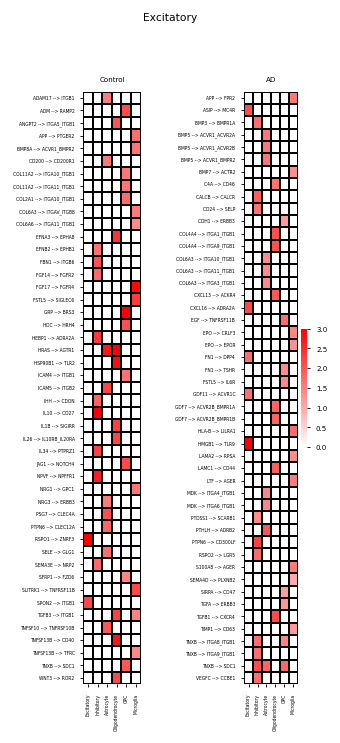

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


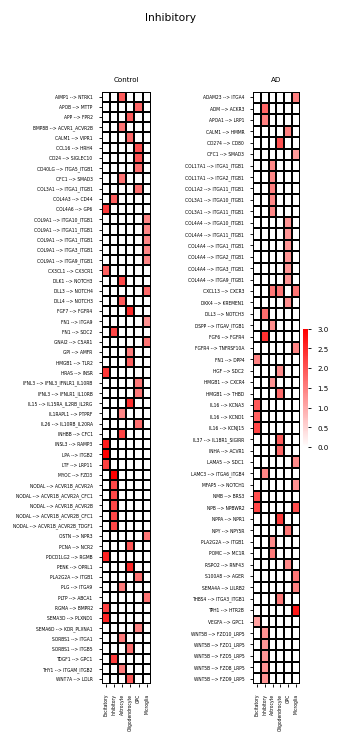

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


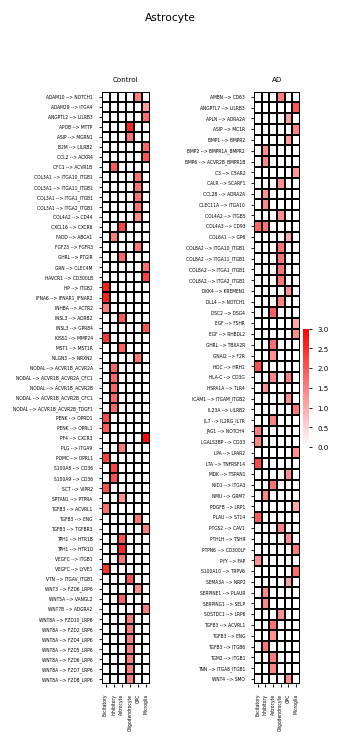

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


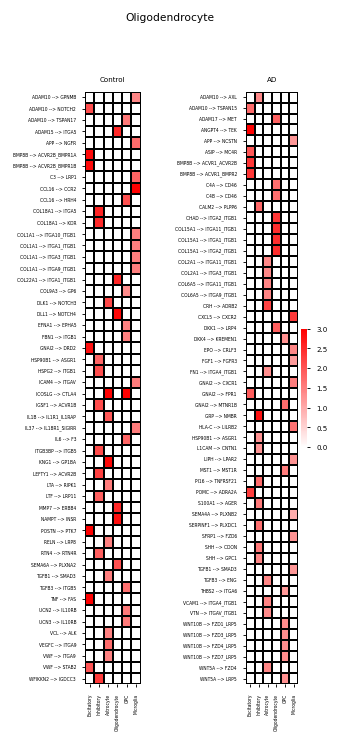

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


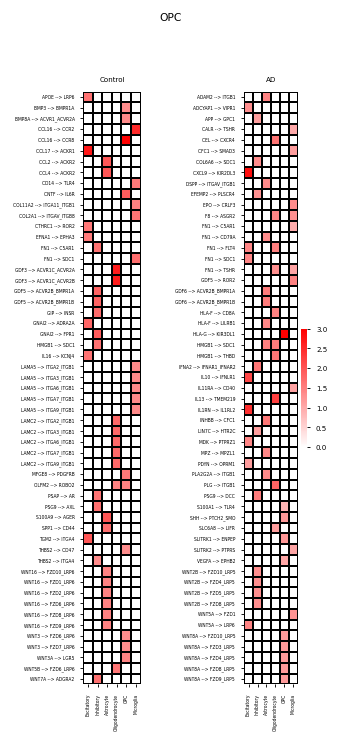

/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
/var/folders/c1/8tpkntr176v0pt5_bk6zhrp40000gn/T/ipykernel_9411/2180398591.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/temitopeleke/miniforge3/envs/mathys_reproduce_arm64/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10


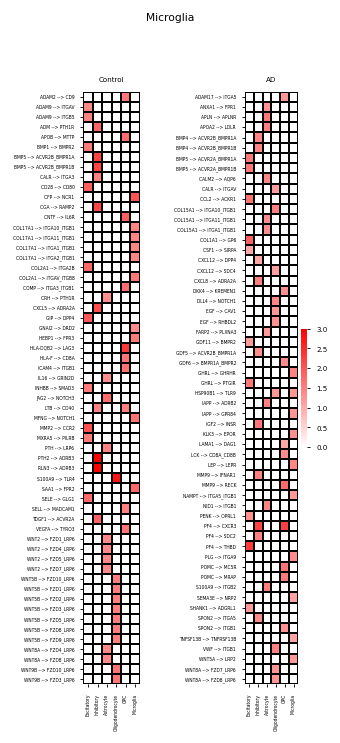

In [18]:
plot_interaction_scores(adata_cond, top_n=10, cell_types=['Excitatory', 'Inhibitory', 'Astrocyte', 'Oligodendrocyte', 'OPC', 'Microglia']) 